<div class="report-header"><div class="aictx-logo"></div>
<span class="report-type">Documentation</span><br />
<span class="report-author">Author: Felix Bauer</span><br />
<span class="report-date">27th May, 2019</span>
</div><h1>DynapseControl:</h1><h1>Interface for cortexcontrol</h1>

This document illustrates how to use the `dynapse_control` module to interface `cortexcontrol` and the DynapSE processor.

##### Housekeeping and import statements


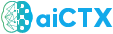

In [1]:
# - Initialisation code to include custom report styles
from IPython.core.display import HTML
def css_styling():
    styles = open("aictx-report.css", "r").read()
    return HTML(styles)
css_styling()

The `DynapseControl` class provides higher-level functionality for `cortexcontrol` and allows the `NetworksPython` framework to interact with the DynapSE processor. However, it can also be used from outside `NetworksPython`.

<br>

## Setup

<br>

### Cortexcontrol

In order to work interface the DynapSE chip, this layer relies on `Cortexcontrol`. It can either be used from within the `Cortexcontrol` console or via an `RPyC` connection. In order to run some examples from within this jupyter notebook, we will do the latter. For this we start `Cortexcontrol` and run the following commands in its console (not in this notebook):

If the `cortexcontrol` console prints <br>
<i>"RPyC: Ready to start."</i> <br>
and nothing else, it is ready. Now through your usual python setup (console, iPython, jupyter, ...) you can import the class and instantiate a `DynapseControl` object.

<br>

### <a name="connect"></a>Connecting to corexcontrol

You can either import only the `DynapseControl` class from the `NetworksPython` package or the complete `dynapse_control` module.

Note that **before using a chip on the DynapSE, you should make sure that it has been cleared** since the current  `cortexcontrol` instance has been started. The methods mentioned above, under _Connecting to Cortexcontrol_ will do so automatically, if you pass a list with the corresponding chip IDs to the `initialize_chips` argument. Otherwise, if you already have an existing connection, you can use the function `dynapse_control.initialize_hardware` and pass the connection as `connection` argument as well as a list of chip IDs with the `use_chips` argument.


In [ ]:
# - Import module
from NetworksPython.devices import dynapse_control as dc

# - Alternatively, only import the DynapseControl class
from NetworksPython.devices import DynapseControl

#### Connecting to Cortexcontrol and instantiating a DyanpseControl object

If you are running the code from without the `cortexcontrol` console, you need to set up an `RPyC` connection to it. There are different ways of doing so:

* Simply instantiate a `DynapseControl` object. In theory, you do not need to pass any arguments. However, if you have not cleared any chips since `cortexcontrol` was connected to the hardware, you should use the `init_chips` argument to pass a list with the IDs of the chips that you are going to use. If (and only if) those chips have not been cleared since starting `cortexcontrol` this will be done now. Apart from that a connection to `cortexcontrol` will be set up that can be accessed through the `rpyc_connection` attribute. If the code is run within `cortexcontrol`, this attribute will be `None`.

When running multiple instances of `conrtexcontrol` and you want to connect to a specific one, you can specify its port in the `rpyc_connection` argument at instantiation. By default, it will first try port 1300 and, if this does not work, 1301.

In [ ]:
# - Generate DynapseControl instance. Make sure chips 0 and 1 are ready to use.
control = DynapseControl(init_chips=[0,1])

# # - Generate DynapseControl instance. Make sure chips 0 and 1 are ready to use. Use port 1300 for connecting.
# control = DynapseControl(initialize_chips=[0,1], rpyc_connection=1300)

# - RPyC connection object
connection = control.rpyc_connection

* You can also set up a connection manually using the `dynapse_control.setup_rpyc` function. It can then be used as argument when creating a `DynapseControl` instance. Here, the optional `initialize_chips` argument has the same function as explained above. You can specify a port using the optional `connect` argument.

* In case you already have a connection, which has not been generated by any of the methods above, you should run the function `dynapse_control.setup_rpyc` with this connection as argument, to make sure that everything is set up correctly to be used with this module.

Note that there can only be one connection to each `cortexcontrol` instance, so the code below is commented out. 

In [ ]:
# # - Manually connect to cortexcontrol
# connection = dc.setup_rpyc(initialize_chips=[0,1])
# 
# # # - Manually connect to cortexcontrol through port 1300
# # connection = dc.setup_rpyc(initialize_chips=[0,1], connect=1300)
# 
# # # - Use existing connection and make sure that everything is set up correctly.
# # # existing_connection = ...
# # # connection = dc.setup_rpyc(connect=existing_connection)
# 
# # - Generate DynapseControl instance, using existing connection
# control = DynapseControl(rpyc_connection=connection)

#### Additional arguments to DynapseControl

There are additional (optional) arguments when instantiating a `DynapseControl` object, that have not been mentioned above:

`fpga_isibase` is a `float` determines the time step size of the inter-spike intervals between events that are sent to the processor. For more details, see [FPGA](#fpga).

`clearcores_list` can either be `None` or a list of integers. In the latter case the configurations of cores with corresponding IDs are wiped, so that  previously set synaptic connections, that the user may not aware of, are removed. To be more precise, the CAMs (pre-neuron IDs and pre-neuron core IDs) and the SRAMs (target chip ID, virtual core ID, core mask) are cleared.

**Overview over all arguments:**

| Argument | Type | Default | Meaning |
|----------|------|---------|---------|
| `fpga_isibase` | `float`| `2e-5` | Time step for sending data to hardware |
| `clearcores_list` | `list` or `None` | `None` | IDs of cores whose configuration should be cleared. |
| `rpyc_connection` | `str`, `int`, `rpyc connection` or `None` | `None` | Connection to `cortexcontrol` or port through which connection should be established. |
| `init_chips` | `list` or `None` | `None` | IDs of chips that are going to be used. |



<br>

## Hardware

Before we go into the details of how the class works, let us first have a brief look at some properties of the DynapSE.

The DynapSE processor consists of 4 chips. Each chips has 4 cores of 256 neurons. The chips, as well as each core in a chip and each neuron in a core are identified with an ID between 0 and 3 or 0 and 256, respectively. However, the `DynapseControl` class uses logical IDs from 0 to 4095 that range over all neurons. In other words the logical neuron ID is $1024 \cdot \text{ChipID} + 256 \cdot \text{CoreID} + \text{NeuronID}$.

<br>

### Setting connections

<br>

#### Synapse types
There are four different synapse types on the DynapSE: fast and slow excitatory as well as fast and slow inhibitory. Each neuron can receive inputs through up to 64 synapses, each of which can be any of the given types. Via `cortexcontrol` the synaptic behavior can be adjusted for each type and for each core, but not for individual synapses.

There is a priori no difference between slow and fast excitatory synapses, so they can be set to have the same behavior. In fact, one could assign shorter time constants to the "slow" excitatory synapses, making them effectively the fast ones. While both excitatory and the fast inhibitory synapses work by adding or subtracting current to the neuron membrane, the slow inhibitory synapses use shunt inhibition and in practice silence a neuron very quickly.

Note that all synapses that are of the same type and that are on the same core have the same weight. Different connection strengths between neurons can only be achieved by setting the same connection multiple times. 

<br>

#### Understanding the routing scheme
In particular if you want to implement complex or large networks that span over several cores, it is helpful to understand how connections are set on the DynapSE. Each neuron has 4 SRAM and 64 CAM cells. 

<br>

##### <a name="sram"></a>SRAM
The SRAM cells determine where each neuron sends its output events, in other words, this will affect postsynaptic connections of the neuron. You can specify the following parameters:
- `target_chip_id` $\in [0, 4)$: ID of chip to which events are sent.
- `core_mask` $\in [0, 16)$: This value is converted to a 4-digit binary value, where each digit corresponds to one core and determines if this core receives events (1) or not (0).
- `virtual_core_id` $\in [0, 4)$: Neurons receive events from specific cores (see [CAM](#cam)). If this value is changed, the sending neuron pretends that it belongs to a different core than it actually does.

Because each neuron has 4 SRAM cells it can in theory send events to up to 4 chips. However, the first SRAM cell is used for routing events to the FPGA, which is necessary to monitor the neuron's activity in `cortexcontrol`. <b>Therefore the first SRAM cell should only be changed if there is no need to observe this neuron's firing activity.</b>

<br>

##### <a name="cam"></a>CAM
In each CAM cell the neuron can be set to listen to (i.e. receive events from) one other neuron. In other words, presynaptic connections are set here. The following parameters can be set:
- `pre_neuron_ID` $\in [0, 256)$: The presynaptic neuron's ID within its core.
- `pre_neuron_core_ID` $\in [0, 1024)$: The core of the presynaptic neuron.

These two values together uniquely define a presynaptic neuron on a single chip. From which chips the postsynaptic neuron receives the events is determined by which neurons (with corresponding ID and core) send to the core where the postsynaptic neuron is located (i.e. the presynaptic neurons must have matching `target_chip_id` and `core_mask` in their [SRAMs](#sram).
- `type`: The synapse type of this connection.
The `type`s are `DynapseCamType` objects: `FAST_EXC`, `SLOW_EXC`, `FAST_INH` or `SLOW_INH`. Using the `DynapseControl` class these synapse typse can be accessed as `DynapseControl.<type>`, where `<type>` is `syn_exc_fast`, `syn_exc_slow`, `syn_inh_fast`, `syn_inh_slow`, respectively.

Becuase each neuron has 64 CAM cells, it can have at most 64 presynaptic connections.
Nevertheless, in theory you can route several neurons' events to a single presynaptic connection if they have the same ID by setting their `virtual_core_id` to the same value in their SRAMs, matching the `pre_neuron_core_ID` of the postsynaptic neuron.

<br>

##### <a name="aliasing"></a>Connection aliasing
The neuron CAMs only store the core and neuron IDs of presynaptic neurons but not the chip ID. This means that the neuron is not able to distinguish between events from different chips if they originate from neurons with same core and neuron IDs.

To understand the implications of this consider the following scenario: Two neurons are on the same core. The first has a presynaptic connection to neuron 2 on core 1 of chip 0. The second neuron has a presynaptic connection to neuron 2 on core 1 of chip 1. Therefore the SRAMs of the two presynaptic neurons are both set to route events to the core where the two postsynaptic neurons sit. Because  both postsynaptic neurons are set to listen to events with core ID 0 and neuron ID 2, each of them will receive events from *both* the presynaptic neurons, although this was not intended. 

Nevertheless there are scenarios in which this is exploited to increase the fan-in of a neuron. By routing events from neurons of different chips but with same core and neuron IDs to one core, a neuron now can listen to as many neurons as there are chips by only using one CAM cell.

<br>

##### Virtual core IDs
In each SRAM a virtual core ID can be set. This means that corresponding events appear to originate from a different core (but the same neuron ID). This can be used to route events from multiple sources to the same postsynaptic neuron by only using one of its CAM cells. The presynaptic neurons must be on different cores but have same neuron IDs and same virtual core IDs in the respective SRAM cells.

Apart from that one may use virtual core IDs to avoid connection aliasing. If in the scenario described [above](#aliasing), one of the two presynaptic neurons changes its virtual core ID, they will not be confused anymore. - Of course, however, there may be new clashes now with a different neuron that has a corresponding core ID.

For changing the virtual core ID with the `DynapseControl` class you can access the neurons through `DynapseControl.lShadowNeurons`, which is a list with references to all ([shadow state](#shadow)) neurons ordered by their logical ID. Here you can manipulate SRAM and CAM cells. Subsequently you will need to call `DynapseControl.model.apply_diff_state()` to apply the changes to the hardware. For more details on how to work with the SRAMs and CAMs see the <a href="http://ai-ctx.gitlab.io/ctxctl/primer.html#CtxDynapse.DynapseNeuron">cortexcontrol documentation</a>.

<br>

##### Practical consequences
The routing scheme has a few practical implications that should be considered when setting up networks on the DynapSE:
- Based on the number of SRAMs per neuron, a neuron's fan-out is limited to 3 *chips* (4, if the neuron's firing activity does not need to be monitored). On these chips an arbitrary number of neurons can be targeted. With 1024 neurons per chip, the maximum fan-out is therefore 3072 (or 4096).
- Based on the number of CAMs per neuron, a neuron's fan-in is generally limited to 64 neurons. However, this can be extenden by assigning the same virtual core ID to neurons with on different cores. This way the fan-in can in theory be multiplied by at most the number of available cores (e.g. on a DynapSE development kit 16). Furthermore, connection aliasing could be used to multiply the fan-in by the number of available chips (i.e. 4 on a development kit).
- Connection aliasing might occur. Therefore, scenarios where two or more neurons on the same core have presynaptic connections to different neurons on different chips but with same core and neuron IDs should be avoided. In the future, the `DynapseControl` class warns, when connection aliasing occurs.

<br>

### Sending events

<br>

#### <a name="virtual_neurons"></a>Virtual neurons
Inputs are sent to the hardware through so-called virtual neurons. Every virtual neuron on the DynapSE has a logical ID, which ranges from 0 to 1023.  An event that is sent to the hardware translates into a virtual neuron emitting a spike.

If a physical neuron $m$ is set to receive spikes from a neuron with logical ID $n$, it makes no difference if a virtual or a pysical neuron with this ID is firing (as long as the firing neuron's target chip IDs and core masks include the location $m$). Neuron $m$ will receive the spikes in both cases. Because this can cause unexpected behavior it is recommended that the IDs of the physical neurons are pairwise different from the IDs of of the virtual neurons.

#### <a name="fpga"></a>FPGA
As for now it is not possible with `DynapseControl` to stream events continuously to the DynapSE. Instead, events are first sent to an FPGA, temporarily stored there and then translated to spikes of virtual neurons, with temporal order and inter-spike intervals matching the input signal. The number of events that can be sent at once is limited to $2^{16} - 1 = 65535$. Longer inputs need to be split up.

Inter-spike intervals must be multiples of a time step, which in `DynapseControl` is stored as `tFpgaIsiBase`. This time step, in return,  needs to be a multiple of $11.\overline{1} \cdot 10^{-9} \text{ s}$.

Although the size of `fpga_isibase` has no effect on computation time, it is not always advisable to choose the smallest possible value. The reason is that the number of timesteps between two input spikes is limited to $2^{16}-1 = 65535$. This means that with `fpga_isibase` $= 11.\overline{1} \cdot 10^{-9} \text{ s}$, any inter-spike interval longer than about 0.73 milliseconds is already above the limit. `DynapseControl` will automatically split up inter-spike intervals that are too long by inserting "dummy" events that are not routed to any neuron on the chip. However, if too many are inserted, the maximum number of input events can be exceeded and the input will have to be split up. In this case a ValueError will be raised.

Therefore it makes sense to set `fpga_isibase` to something between $10^{-6}$ and $10^{-4}$ seconds, in order to allow for sufficiently long silent parts in the input while still maintaining a good temporal resolution. Alternatively one could send dummy events that do not target any physical neuron. However, transmission of events to the processor is not the fastest and the more events are sent, the longer it takes.

<br>

### Receiving events
In order to record the firing activity of neurons `EventFilter` and `BufferedEventFilter` objects can be used. Each can be set to listen to a specific population of neurons. `EventFilter`s will call a callback function, each time one of the specified neurons fires. `BufferedEventFilter`s will store `event` objects in a buffer until they are fetched. For more details refer to the <a href="http://ai-ctx.gitlab.io/ctxctl/primer.html#CtxDynapse.EventFilter">cortexcontrol documentation</a>.

Currently the `DynapseControl` class only supports the use of a single `BufferedEventFilters`, which can be added or changed with the `add_buffered_event_filter` method. It will stop recording when the `clear_buffered_event_filter` method is called.

<br>

### Time constants for neurons
For each core the neuron time constants can be set through the biases `IF_TAU1_N` and `IF_TAU2_N`. Higher values correspond to shorter time constants and effectively make it less likely that the neurons will fire. For each neuron you can choose which of the two time constant biases applies. This can be useful, for example by setting the value of `IF_TAU2_N` very high, making it almost impossible for a neuron to fire. Neurons that fire in an uncontrollable way (so-called hot neurons) can then be silenced by assigning them `TAU2` instead of `TAU1`.
Neurons are assigned `TAU2` with the `silence_neurons` method. All neurons of specified cores are assigned `TAU1` with the `reset_silencing` method. Note that the names of these methods are chosen under the assumption that the bias for `TAU2` has been set to a high value. The neurons are not silenced per se by those methods.


<br>

### Neuron allocation
To avoid multiple layers (such as the `RecDynapSE` class) referencing the same neurons on the hardware, `DynapseControl` keeps track of which neurons are already in use. The same happens for [virtual neurons](#virtual_neurons). An array with a boolean for each (virtual) neuron that indicates whether it is still available can be accessed through `DynapseControl.hwneurons_isavailable` (`DynapseControl.virtualneurons.isavailable`). If a layer wants to be assigned a population of (virtual) neurons, it can call `DynapseControl.allocate_hw_neurons` (`DynapseControl.allocate_virtual_neurons`). If an array of integers is passed as argument, the method will try to assign the neurons with corresponding logical IDs or raise a `ValueError` if some of them are already assigned. If an integer $n$ is passed, it will assign $n$ available neurons. In both cases an array with the logical IDs of the assigned neurons is returned and the neurons are marked as not free.

Note that only neurons are available that are on chips that have been cleared since the current instance of `cortexcontrol` has been started (see [connecting with cortexcontrol](#connect)).

<br>

#### Rectangular neuron arangement
Locating a specific neuron within a population visually in the `cortexcontrol` GUI is easier, if the neurons of the population are arranged in a rectangle on the chip. The `dynapse_control` module provides a function `rectangular_neuron_arrangement` that helps in determining the IDs of neurons in such an arrangement.

<br>

### <a name="shadow"></a>Shadow state neurons
In order to update connections more efficiently, `cortexcontrol` uses shadow state neurons, that are virtual representations of the actual hardware neurons. After changing any attribute of a shadow state neuron, the hardware neurons are only updated after `DynapseControl.model.apply_diff_state()` has been called. This allows for a more efficient update mechanism, in particular if only few neurons have been modified. To access shadow state neurons from within the `DynapseControl` class, there is the `shadow_neurons` attribute, a list with references to all shadow state neurons ordered by their logical ID. By any means, do not use the `hw_neurons` attribute, as this will cause unexpected behavior.

<br>

## Methods overview
Now that a `DynapseControl` has been instantiated, there are many ways of using it to interact with the hardware. This section will give an overview over all mehtods that are currently implemented. For more details please consult the documentation within the source code. 

<br>

### Neuron allocation and connections

`allocate_hw_neurons`<br>
Allocate neurons if available and return them in lists.

`allocate_virtual_neurons`<br>
Allocate virtual neurons if available and return them in list.

`add_connections_to_virtual`<br>
Connect populations of virtual and physical neurons.

`set_virtual_connections_from_weights`<br>
Set connections from virtual to physical neurons from weight matrix.

`set_connections_from_weights`<br>
Set connections between two neuron populations from weight matrix. Presynaptic neurons can be virtual. Existing connections to postsynaptic neurons will be removed.

`add_connections_from_weights`<br>
Add connections between two neuron populations from weight matrix. Presynaptic neurons can be virtual. Existing connections to postsynaptic neurons will **not** be removed.

`remove_all_connections_to`<br>
Remove all presynaptic connections to specified neurons.

<br>

### Resetting

`initialize_chips` <br>
Clear chips with given IDs.

`clear_neuron_assignments` <br>
Mark neurons on given cores as free.

`clear_connections` <br>
Reset connections for specified cores.

`reset_silencing` <br>
Assign time constant `TAU1` to all neurons on specified cores.

`reset_cores` <br>
Reset neuron assignments, time constants and presynaptic connections for specified cores.

`reset_all` <br>
Reset neuron assignments, time constants and presynaptic connections for all cores.

<br>

### Stimulation and event generation
`start_cont_stim`<br>
Start sending events to processor with fixed frequency.

`stop_stim`<br>
Stop any ongoing stimulation except poisson-rate stimulation.

`start_poisson_stim`<br>
Start generating events by poisson processes and send them.

`stop_poisson_stim`<br>
Stop generating events by poisson processes and send them.

`reset_poisson_rates`<br>
Set rates for poisson event generation to 0.

`send_pulse`<br>
Send a pulse of periodic input events.

`send_TSEvent`<br>
Extract events from a `TSEvent` object and send them to the processor. Can record neuron activity simultaneously.

`send_arrays`<br>
Extract events from arrays (times and channels) and send them to the processor. Can record neuron activity simultaneously.

`record` <br>
Record activities of neurons with given IDs. Either for specific time or until `stop_recording` is called.

`stop_recording` <br>
Stop recording and return events that have been recorded with current `BufferedEventFilter`.

<br>

### Tuning and observing activities

`add_buffered_event_filter`<br>
Add a `BufferedEventFilter` to record activities from specified neurons.

`clear_buffered_event_filter`<br>
Stop recording neuron activities.

`collect_spiking_neurons`<br>
Return a list of neurons that spike during a specified time.

`silence_neurons` <br>
Set time constant to `TAU2` for specified neurons.

`silence_hot_neurons`<br>
Set time constant to `TAU2` for neurons that spike during specified time.

`measure_population_firing_rates`<br>
Measure firing rates for multiple neuron populations.

`measure_firing_rates`<br>
Measure firing rates of specified neurons.

`monitor_firing_rates`<br>
Start periodically printing the average firing rates for specified neurons.

`stop_monitor`<br>
Stop measuring and printing firing rates.

`sweep_freq_measure_rate`<br>
Stimulate a group of neurons by sweeping over a list of input frequencies. Measure their firing rates.

<br>

### Load and save biases

`load_biases`<br>
Load biases from file.

`save_biases`<br>
Save biases to file.

`copy_biases`<br>
Copy biases from one core to other(s).

<br>

## Using RPyC

This section contains useful information if you want to contribute own methods for interacting with the processor.

In order to communicate with `cortexcontrol`, the `dynapse_control` module uses the `RPyC` package (https://rpyc.readthedocs.io/en/latest/), which establishes a connection where `cortexcontrol` acts as a server that can execute python commands sent by the `dynapse_control` module. 
<br>

#### Adding objects to `cortexcontrol` namespace
It is important to note that `cortexcontrol` uses its own python interpreter with its own namespace. Therefore you need to make sure that objects and modules that are to be used there are properly defined. An `RPyC` connection has a dictionary-like attribute called `namespace`, where you can add items in order to add an object to the namespace of `cortexcontrol`, like in the following example:

In [ ]:
# - Define some object
numbers = [1,2,3,4,5]
# - Make it accessible in the namespace of cortexcontrol
connection.namespace["numbers"] = numbers

#### Using built-in python modules
You can use built-in python modules such as `copy`, `time`, etc. within the `cortexcontrol` environment. For this you need to add `connection.modules.<built-in name>` to `connection.namespace`:

In [ ]:
# - Add copy module to cortexcontrol namespace
connection.namespace["copy"] = connection.modules.copy

For connections that have been created via `dynapse_control.setup_rpyc` or during the instantiation of a `DynapseControl` object, the following modules are already registered in the namespace:

* copy
* os
* rpyc
* ctxdynapse (for direct access to cortexcontrol objects)


<br>

### Pitfalls

<br>

#### Non-built-in objects
 no additional packages available other than `RPyC`. This means it will not be able to run commands that use non-built-in packages. Even though sometimes it can process corresponding objects, such as `numpy.ndarray`s, it is in general safer to convert such objects into similar built-in objects, such as lists. 

<br>

#### Data transfer
Repeatedly sending even small chunks of data through the `RPyC` connection takes a lot of time and should be avoided. This can happen for instance in loops that use objects on the other side of the connections. For example, a function in `dynapse_control` that loops over objects from the `cortexcontrol` environment, such as neurons, will be very inefficient:

In [ ]:
from time import time

# - Reference to ctxdynapse module, which allows direct access to objects of cortexcontrol
ctxdynapse = connection.namespace["ctxdynapse"]

t0 = time()

## -- Inefficient, avoid such loops:
# - List of neurons - lives on other side of connection
neuron_list = ctxdynapse.model.get_neurons()
# - List of neuron IDs
id_list = []
for neuron in neuron_list:
    # - At each iteration, data will be transferred to this side of the connection
    id_list.append(neuron.get_id())
print("Took {} s".format(time()-t0))

A better solution in this case would be to define a function that lives on the `cortexcontrol`-side (using the `teleport_function` or `remote_function` wrappers - more details below) and generates the list there before sending it our side:

In [ ]:
## -- Better: Process objects locally, send data only once

# - Define decorator to teleport function through existing connection
teleport = lambda func : dc.teleport_function(connection, func)

# - Define function on other side of connection wiht teleport decorator
@teleport
def get_neuron_ids():
    neuron_list = ctxdynapse.model.get_neurons()
    # - List of neuron IDs
    id_list = []
    for neuron in neuron_list:
        # - Data remains on one side of connection
        id_list.append(neuron.get_id()) 
    return id_list
t0 = time()

id_list = get_neuron_ids()

print("Took {} s".format(time()-t0))

Be careful with function arguments and returns - an object will live on the side of the connection where it has been created. Use the `copy` module (or `deepcopy` for nested objects) to make sure, all data is transmitted to where you want to work with it. 

You can always see where an object lives by using `print(type(<object>))`. If the object is on the other side of the connection, its type will contain `netref`. This is always relative to the place where the command is called, so if it is called from within a funciton on the `cortexcontrol`-side and the output contains `netref`, the object is on the `dynapse_control`-side. A print statement called within `cortexcontrol` will print into the `cortexcontrol`-console.

In [ ]:
import copy

# - List still lives in cortexcontrol. Looping over it would be inefficient.
id_list = get_neuron_ids()
print(type(id_list))
# - Copy it to this side 
id_list = copy.copy(id_list)
print(type(id_list))

Be particularly careful with container objects, such as lists. It may happen that the container lives on a different side of a connection than its contained elements. This will inevitably cause performance issues.

One especially perfidious case are numbers that originate from `numpy` functions. They are often `numpy`-specific types such as `np.int64`. Even if you convert an array containing such numbers to a list, they will be of this special type. When this list is sent to a function on the other side of the loop, they will remain on your side of the connection, and `copy` or `deepcopy` on the `cortexcontrol`-side can't handle them. You should therefore loop over them and convert them to normal `int`s or `float`s. We will see below that there is a way to do this (semi-) automatically. The following code cell will throw an execption while the next one works.

In [ ]:
# - Print type of elements in lNumbers in cortexcontrol-console
@teleport
def print_element_type(numbers: list):
    print(type(numbers[0]))

# - Try using (deep-)copy on lNumbers
@teleport
def print_element_type_copy(numbers: list):
    # - List is on correct side
    print(type(numbers))
    # - ...its elements not necessarily
    print(type(numbers[0]))
    # - (deep-)copy does not help
    numbers = copy.copy(numbers)
    # lNumbers = copy.deepcopy(lNumbers)
    print(type(numbers[0]))

# - Elements in lNumbers are not normal integers
numbers = list(np.random.randint(10, size=5))
print(type(numbers[0]))

print_element_type(numbers)  # - Will print type of first element in lNumbers in cortexcontrol-console.
                              #   Not that it is a netref.
print_element_type_copy(numbers)  # - Will throw an exception

In [ ]:
# - Convert elements to normal integers
numbers = [int(n) for n in numbers]
print_element_type(numbers)  # - Will print type of new elements in cortexcontrol-console

<b>In summary, there are three rules that you should always respect:</b>
1. Do not use non-built-in types on the cortexcontrol side of the connection.
2. Avoid loops containing objects on the other side of the connection.
3. Copy data to the corresponding side before processing them. Be careful with nested types.

In the following we will see a few tools that help complying with these rules.

### Defining objects and functions on cortexcontrol-side

<font color="red">
    
- Difference between where object lives and where it is defined.
- How to include objects, modules and functions in cortexcontrol-namespace

- Define functions on cortexcontrol-side (teleport_function, remote_function)

- Make sure objects (function arguments) are only built-in types
- Make sure objects (function arguments) live on correct side of connection
</font>


#### Colophon
Live notebook requires a Jupyter Notebook server.

GitLab repository location: https://gitlab.com/ai-ctx/network-architectures/blob/master/Projects/Documentation/FFCLIAF%20and%20RecCLIAF.ipynb